# Optimizers
---
***Author: Piotr Skalski***

## Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import time
import pprint 

# my implementation of a densely connected neural network 
import fully_connected_nn

## Settings

In [2]:
# neural network architecture
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

# number of samples in the data set
N_SAMPLES = 1000

# ratio between training and test sets
TEST_PERCENTAGE = 0.1

# number of epochs
N_EPOCHS = 5000

# learning rate value
LR = 0.01

## Auxiliary functions

### Dataset chart 

In [3]:
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    
    if(file_name):
        plt.savefig(file_name)
        plt.close()

### Linear chart of accuracy or cost function

In [4]:
def make_graph(data_y, labels, colors, plot_name, file_name=None):
    plt.figure(figsize=(16,12))
    plt.style.use('dark_background')
    
    for series, color in zip(data_y, colors):
        plt.plot(series, color, lw=2)

    plt.title(plot_name, fontsize=30)
    plt.ylabel('')
    plt.xlabel('iteration')
    plt.legend(labels, loc='upper left', prop={'size': 15})
    
    if(file_name):
        plt.savefig(file_name)
        plt.close()

## A simple task comparing the performance of different algorithms

### Create artificial dataset

In [5]:
X1, y1 = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X2, y2 = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=0)
X2[:, 0] = X2[:, 0] + 2
X = np.concatenate((X1, X2))
y = np.concatenate((y1, y2))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_PERCENTAGE, random_state=42)

# Preparation of the data set. Subsequent examples should be stored in subsequent columns. 
# We need to transpose the datasets.

X_train = np.transpose(X_train)
y_train = np.transpose(y_train.reshape((y_train.shape[0], 1)))
X_test = np.transpose(X_test)
y_test = np.transpose(y_test.reshape((y_test.shape[0], 1)))

### Visualization of the dataset

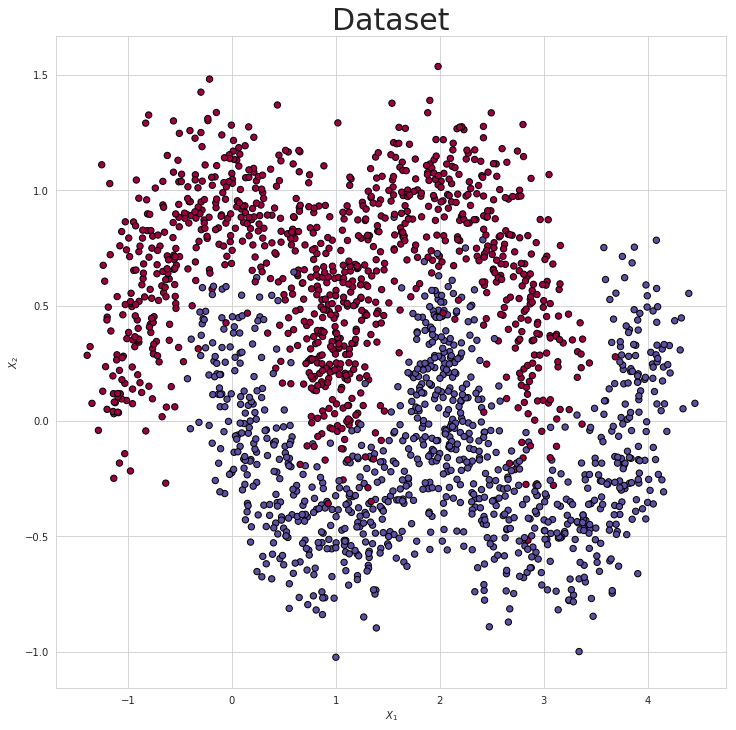

In [6]:
make_plot(X, y, "Dataset")

## Basic gradient descent

### Training

In [7]:
start = time.time()

params_values_base, cost_history_base, accuracy_history_base = fully_connected_nn.train(
    X_train, y_train, NN_ARCHITECTURE, N_EPOCHS, LR)

end = time.time()
train_time_base = end - start
print("Train set accuracy: {:.2f}".format(accuracy_history_base[-1]))
print("Training time: {:.2f} sec".format(train_time_base))

Train set accuracy: 0.87
Training time: 55.54 sec


### Making predictions

In [8]:
Y_test_hat_base, _ = fully_connected_nn.full_forward_propagation(X_test, params_values_base, NN_ARCHITECTURE)

In [9]:
acc_test_base = fully_connected_nn.get_accuracy_value(Y_test_hat_base, y_test)
print("Accuracy: {:.2f}".format(acc_test_base))

Accuracy: 0.84


## Mini-batch gradient descent

### Implementation of train function using mini-batches

In [10]:
def train_batch(X, Y, nn_architecture, epochs, learning_rate, batch_size = 64, verbose=False, callback=None):
    params_values = fully_connected_nn.init_layers(nn_architecture, 2)
    cost_history = []
    accuracy_history = []
    
    # Beginning of additional code snippet
    examples_size = X.shape[1]
    batch_number = examples_size // batch_size
    # Ending of additional code snippet
    
    for i in range(epochs):
        # Beginning of additional code snippet
        batch_idx = epochs % batch_number
        X_batch = X[:, batch_idx * batch_size : (batch_idx + 1) * batch_size]
        Y_batch = Y[:, batch_idx * batch_size : (batch_idx + 1) * batch_size]
        # Ending of additional code snippet
        
        Y_hat, cashe = fully_connected_nn.full_forward_propagation(X_batch, params_values, nn_architecture)
        
        cost = fully_connected_nn.get_cost_value(Y_hat, Y_batch)
        cost_history.append(cost)
        accuracy = fully_connected_nn.get_accuracy_value(Y_hat, Y_batch)
        accuracy_history.append(accuracy)
        
        grads_values = fully_connected_nn.full_backward_propagation(Y_hat, Y_batch, cashe, params_values, nn_architecture)
        params_values = fully_connected_nn.update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values, cost_history, accuracy_history

### Training

In [11]:
start = time.time()

params_values_batch, cost_history_batch, accuracy_history_batch = train_batch(
    X_train, y_train, NN_ARCHITECTURE, N_EPOCHS, LR, 64)

end = time.time()
train_time_batch = end - start
print("Train set accuracy: {:.2f}".format(accuracy_history_batch[-1]))
print("Training time: {:.2f} sec".format(train_time_batch))

Train set accuracy: 0.86
Training time: 2.92 sec


### Making predictions

In [12]:
Y_test_hat_batch, _ = fully_connected_nn.full_forward_propagation(X_test, params_values_batch, NN_ARCHITECTURE)

In [13]:
acc_test_batch = fully_connected_nn.get_accuracy_value(Y_test_hat_batch, y_test)
print("Test set accuracy: {:.2f}".format(acc_test_batch))

Test set accuracy: 0.81


## Gradient descent with momentum

### Settings

In [14]:
# proportionality factor for EWA
BETA = 0.9

### Auxiliary functions

In [15]:
def calculate_ewa(previous_ewa, current_value, beta):
    return beta * previous_ewa + (1 - beta) * current_value

In [16]:
def update_momentum(grads_values, grads_momentum, beta):
    output = {}
    # check if the dictionary that holds the momentum is empty
    if bool(grads_momentum):
        for layer, grad_value in grads_values.items():
            momentum_value = grads_momentum[layer]
            output[layer] = calculate_ewa(momentum_value, grad_value, beta)
    else:
        output = grads_values
    return output

### Implementation of train function using gradient descent with momentum

In [17]:
def train_momentum(X, Y, nn_architecture, epochs, learning_rate, beta, batch_size = 64, verbose=False, callback=None):
    params_values = fully_connected_nn.init_layers(nn_architecture, 2)
    cost_history = []
    accuracy_history = []
    grads_momentum = {}
    
    # Beginning of additional code snippet
    examples_size = X.shape[1]
    batch_number = examples_size // batch_size
    # Ending of additional code snippet
    
    for i in range(epochs):
        # Beginning of additional code snippet
        batch_idx = epochs % batch_number
        X_batch = X[:, batch_idx * batch_size : (batch_idx + 1) * batch_size]
        Y_batch = Y[:, batch_idx * batch_size : (batch_idx + 1) * batch_size]
        # Ending of additional code snippet
        
        Y_hat, cashe = fully_connected_nn.full_forward_propagation(X_batch, params_values, nn_architecture)
        
        cost = fully_connected_nn.get_cost_value(Y_hat, Y_batch)
        cost_history.append(cost)
        accuracy = fully_connected_nn.get_accuracy_value(Y_hat, Y_batch)
        accuracy_history.append(accuracy)
        
        grads_values = fully_connected_nn.full_backward_propagation(Y_hat, Y_batch, cashe, params_values, nn_architecture)
        grads_momentum = update_momentum(grads_values, grads_momentum, beta)
        params_values = fully_connected_nn.update(params_values, grads_momentum, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values, cost_history, accuracy_history

In [18]:
start = time.time()

params_values_momentum, cost_history_momentum, accuracy_history_momentum = train_momentum(
    X_train, y_train, NN_ARCHITECTURE, N_EPOCHS, LR, BETA, 64)

end = time.time()
train_time_momentum = end - start
print("Train set accuracy: {:.2f}".format(accuracy_history_momentum[-1]))
print("Training time: {:.2f} sec".format(train_time_momentum))

Train set accuracy: 0.86
Training time: 3.39 sec


### Making predictions

In [19]:
Y_test_hat_momentum, _ = fully_connected_nn.full_forward_propagation(X_test, params_values_momentum, NN_ARCHITECTURE)

In [20]:
acc_test_momentum = fully_connected_nn.get_accuracy_value(Y_test_hat_momentum, y_test)
print("Test set accuracy: {:.2f}".format(acc_test_momentum))

Test set accuracy: 0.81


## RMSprop

### Settings

In [21]:
# bafety-related protection for numerical stability
EPS = 0.0000001
# proportionality factor for EWA
BETA = 0.9
# learning rate
LR = 0.1
# number of iterations
N_EPOCHS = 1000

### Auxiliary functions

In [22]:
def calculate_squares_sum(previous_sum, current_value, beta):
    return beta * previous_sum + (1 - beta) * current_value**2

In [23]:
def update_squares_sum(grads_values, grads_squares_sum, beta):
    output = {}
    # check if the dictionary that holds the momentum is empty
    if bool(grads_squares_sum):
        for layer, grad_value in grads_values.items():
            previous_sum = grads_squares_sum[layer]
            output[layer] = calculate_squares_sum(previous_sum, grad_value, beta)
    else:
        for layer, grad_value in grads_values.items():
            output[layer] = grad_value**2
    return output

In [24]:
def update_rmsprop(params_values, grads_values, grads_squares_sum, nn_architecture, learning_rate, eps):
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * (grads_values["dW" + str(layer_idx)]) / (np.sqrt(grads_squares_sum["dW" + str(layer_idx)]) + eps)        
        params_values["b" + str(layer_idx)] -= learning_rate * (grads_values["db" + str(layer_idx)]) / (np.sqrt(grads_squares_sum["db" + str(layer_idx)]) + eps) 

    return params_values

In [25]:
def train_rmsprop(X, Y, nn_architecture, epochs, learning_rate, beta, eps, batch_size = 64, verbose=False, callback=None):
    params_values = fully_connected_nn.init_layers(nn_architecture, 2)
    cost_history = []
    accuracy_history = []
    grads_squares_sum = {}
    
    # Beginning of additional code snippet
    examples_size = X.shape[1]
    batch_number = examples_size // batch_size
    # Ending of additional code snippet
    
    for i in range(epochs):
        # Beginning of additional code snippet
        batch_idx = epochs % batch_number
        X_batch = X[:, batch_idx * batch_size : (batch_idx + 1) * batch_size]
        Y_batch = Y[:, batch_idx * batch_size : (batch_idx + 1) * batch_size]
        # Ending of additional code snippet
        
        Y_hat, cashe = fully_connected_nn.full_forward_propagation(X_batch, params_values, nn_architecture)
        
        cost = fully_connected_nn.get_cost_value(Y_hat, Y_batch)
        cost_history.append(cost)
        accuracy = fully_connected_nn.get_accuracy_value(Y_hat, Y_batch)
        accuracy_history.append(accuracy)
        
        grads_values = fully_connected_nn.full_backward_propagation(Y_hat, Y_batch, cashe, params_values, nn_architecture)        
        grads_squares_sum = update_squares_sum(grads_values, grads_squares_sum, beta)
        params_values = update_rmsprop(params_values, grads_values, grads_squares_sum, nn_architecture, learning_rate, eps)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values, cost_history, accuracy_history

In [26]:
start = time.time()

params_values_rmsprop, cost_history_rmsprop, accuracy_history_rmsprop = train_rmsprop(
    X_train, y_train, NN_ARCHITECTURE, N_EPOCHS, LR, BETA, EPS, 64)

end = time.time()
train_time_rmsprop = end - start
print("Train set accuracy: {:.2f}".format(accuracy_history_rmsprop[-1]))
print("Training time: {:.2f} sec".format(train_time_rmsprop))

Train set accuracy: 0.94
Training time: 0.81 sec


### Making predictions

In [27]:
Y_test_hat_rmsprop, _ = fully_connected_nn.full_forward_propagation(X_test, params_values_rmsprop, NN_ARCHITECTURE)

In [28]:
acc_test_rmsprop = fully_connected_nn.get_accuracy_value(Y_test_hat_rmsprop, y_test)
print("Test set accuracy: {:.2f}".format(acc_test_rmsprop))

Test set accuracy: 0.83


## Summary of obtained results 

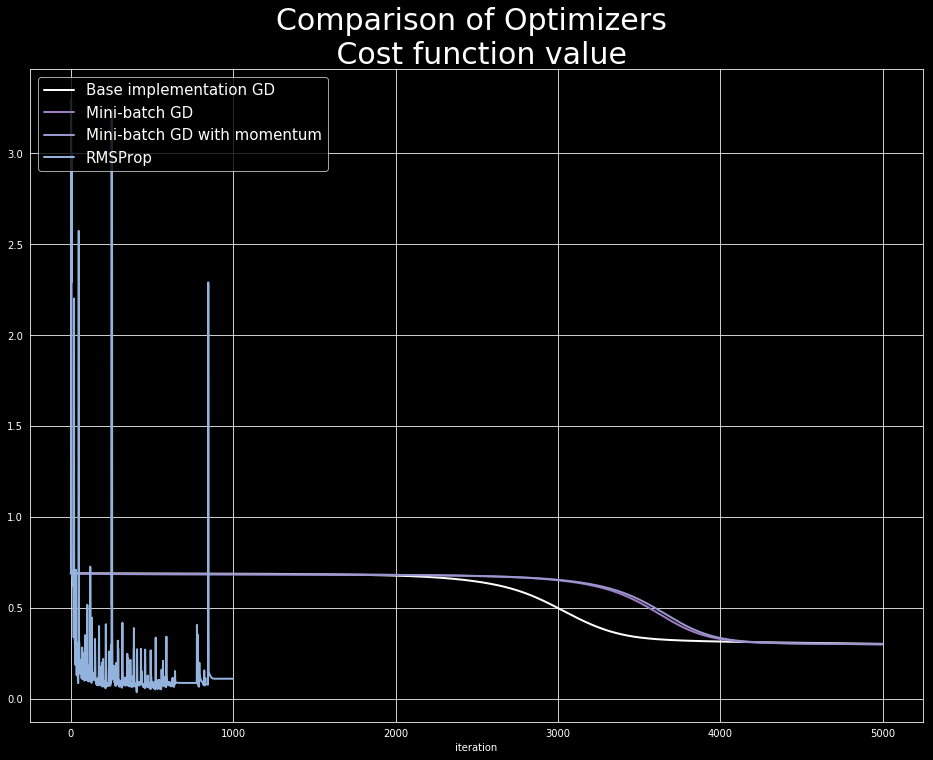

In [31]:
data = [
    cost_history_base,
    cost_history_batch, 
    cost_history_momentum,
    cost_history_rmsprop
]
labels = [
    "Base implementation GD", 
    "Mini-batch GD", 
    "Mini-batch GD with momentum",
    "RMSProp"
]
colors = [
    "#FFFFFF", 
    "#9E7CC1", 
    "#9897CE",
    "#93B2DC"
]

#     "#93B2DC", 
#     "#8ECDEA"

make_graph(data, labels, colors, "Comparison of Optimizers \n Cost function value")

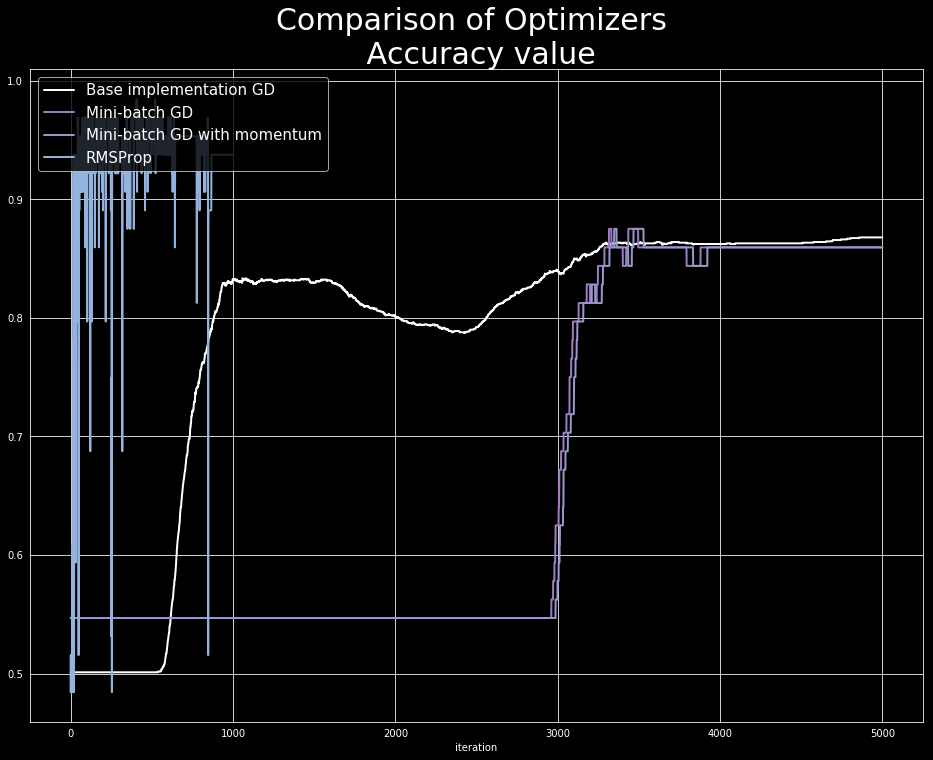

In [30]:
data = [
    accuracy_history_base,
    accuracy_history_batch, 
    accuracy_history_momentum,
    accuracy_history_rmsprop
]
labels = [
    "Base implementation GD", 
    "Mini-batch GD", 
    "Mini-batch GD with momentum",
    "RMSProp"
]
colors = [
    "#FFFFFF", 
    "#9E7CC1", 
    "#9897CE",
    "#93B2DC"
]

#     "#93B2DC", 
#     "#8ECDEA"

make_graph(data, labels, colors, "Comparison of Optimizers \n Accuracy value")